# Introduction

The puprpose of this projects is to do sentiment analysis of IMDB reviews in multiple ways. After building a some models we will choose the best model and we will build a web application that will scan for IMDB reviews of a movie and then rate the movie according to the model.  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers

2023-11-04 14:53:25.387911: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 14:53:25.649265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 14:53:25.649293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 14:53:25.650394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 14:53:25.762777: I tensorflow/core/platform/cpu_feature_g

# Part 1 - Inspecting the dataset
The dataset that we are going to use is IMDB Dataset of 50K Movie Reviews from Kaggle.

In [2]:
dataset = pd.read_csv("IMDBDataset.csv")
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
dataset.shape

(50000, 2)

In [4]:
dataset["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

We need to split the dataset into test and train

In [5]:
from sklearn.model_selection import train_test_split

train_lines, test_lines, train_vals, test_vals =  train_test_split(dataset["review"], dataset["sentiment"], test_size=0.2)

now, we will convert the output to onehot encoded because it will be easier for the model to predict it.

In [6]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_vals.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_vals.to_numpy().reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
test_labels_one_hot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

we will do the same with label encoding:

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_vals.to_numpy())
test_labels_encoded = label_encoder.transform(test_vals.to_numpy())

train_labels_encoded

array([1, 1, 1, ..., 0, 1, 0])

In [9]:
label_encoder.classes_

array(['negative', 'positive'], dtype=object)

# part 2 - creating experiments

## model 0
The first model that I will try as a baseline is a naive-bayes model. We will do Tfidf vectorization to the data and then we will process it.

In [10]:
train_sentences = train_lines.tolist()
test_sentences = test_lines.tolist()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("vectorization layer", TfidfVectorizer()),
    ("BernoulliNB", BernoulliNB())
])

In [12]:
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('vectorization layer', TfidfVectorizer()),
                ('BernoulliNB', BernoulliNB())])

In [13]:
model_0.score(test_sentences, test_labels_encoded)

0.8535

In [14]:
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([1, 0, 0, ..., 0, 1, 0])

Now, we will use calculate results function to get the different types of error metrics in a list.

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [16]:
calculate_results(test_labels_encoded, baseline_preds)

{'accuracy': 85.35000000000001,
 'precision': 0.8550126334391083,
 'recall': 0.8535,
 'f1': 0.8533963861588729}

Our base model preformed with 85% accuracy. Now, let's try building more complex models. We will use embedding and tokenization, to do that we need to find the mean length of the sentences.

In [17]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

231.144975

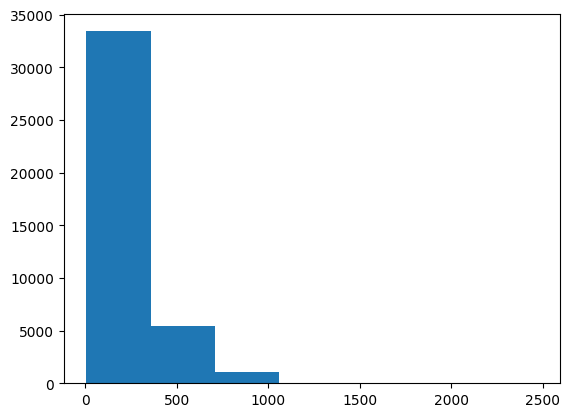

In [18]:
plt.hist(sent_lens, bins=7);

In [19]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

590

In the next part we will try to do text vectorization, we don't know the amount of words in the dataset so we will do it without max_tokens.

In [20]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    output_sequence_length=590)

2023-11-04 14:53:35.799073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 14:53:35.822983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 14:53:35.823017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 14:53:35.825610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 14:53:35.825640: I tensorflow/compile

In [21]:
text_vectorizer.adapt(train_sentences)

In [22]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
This movie was awful! Ashley Rose Orr, while a talented tap dancer, and singer (actually a little better than Temple was in terms of the latter), is a terrible actress. She plays the character as the Shirley that we saw on screen in her movies whether she's playing her onscreen or offscreen persona. So what we get is an overly cutesy, and wholly unrealistic (not to mention uninteresting) portrait. If one wants to see that side of her, one can just rent one of her movies. The only bright light here is Connie Britton's portrayal of Gertrude Temple. I don't think it was terribly realistic, but at least it was well acted. Save yourself the trouble and rent The Poor Little Rich Girl.

Length of text: 123

Vectorized text:
[[    11     18     14    378   6467   2240  29780    134      4   1044
    5365   3625      3   1862    155      4    117    124     73   4197
      14      8   1226      5      2   1580      7      4    376    537
      58    283      2    110     15      2   4252 

In [23]:
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(text_vocab)}"),
print(f"Most common words in the vocabulary: {text_vocab[:5]}")
print(f"Least common words in the vocabulary: {text_vocab[-5:]}")

Number of words in vocabulary: 160780
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'a']
Least common words in the vocabulary: ['0010', '00000110', '00000001', '0000000000001', '\x10own']


Now we will create embedding layer.

In [24]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
This movie was awful! Ashley Rose Orr, while a talented tap dancer, and singer (actually a little better than Temple was in terms of the latter), is a terrible actress. She plays the character as the Shirley that we saw on screen in her movies whether she's playing her onscreen or offscreen persona. So what we get is an overly cutesy, and wholly unrealistic (not to mention uninteresting) portrait. If one wants to see that side of her, one can just rent one of her movies. The only bright light here is Connie Britton's portrayal of Gertrude Temple. I don't think it was terribly realistic, but at least it was well acted. Save yourself the trouble and rent The Poor Little Rich Girl.

Sentence after vectorization (before embedding):
[[    11     18     14    378   6467   2240  29780    134      4   1044
    5365   3625      3   1862    155      4    117    124     73   4197
      14      8   1226      5      2   1580      7      4    376    537
      58    283

After embedding we will create dataset and make it into batches.

In [25]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [26]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

## Model 1 - Conv1d with embedding.

In [27]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
text_embedded = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(text_embedded)
x= layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(2, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [28]:
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 590)               0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 590, 128)          20579840  
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 590, 64)           41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

In [29]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=test_dataset,
                              validation_steps=int(0.1 * len(test_dataset)))

Epoch 1/3


2023-11-04 14:53:54.826592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-04 14:53:57.220642: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f35b41d8950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 14:53:57.220697: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-11-04 14:53:57.232549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-04 14:53:57.340208: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 16s 77ms/step - loss: 0.6581 - accuracy: 0.6497 - val_loss: 0.5676 - val_accuracy: 0.7419
Epoch 2/3
125/125 [==============================] - 8s 68ms/step - loss: 0.4907 - accuracy: 0.7750 - val_loss: 0.4268 - val_accuracy: 0.8095
Epoch 3/3
125/125 [==============================] - 7s 53ms/step - loss: 0.4000 - accuracy: 0.8225 - val_loss: 0.3892 - val_accuracy: 0.8266


In [30]:
model_1.evaluate(test_dataset)

313/313 [==============================] - 2s 5ms/step - loss: 0.3797 - accuracy: 0.8322


[0.3796714246273041, 0.8321999907493591]

In [31]:
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs

313/313 [==============================] - 1s 4ms/step


array([[5.8054965e-04, 9.9941945e-01],
       [9.5379519e-01, 4.6204761e-02],
       [9.3620044e-01, 6.3799530e-02],
       ...,
       [9.9379998e-01, 6.1999727e-03],
       [4.2373684e-01, 5.7626319e-01],
       [9.9514318e-01, 4.8568086e-03]], dtype=float32)

In [32]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 1, 0])>

In [33]:
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 83.22,
 'precision': 0.8371680214169231,
 'recall': 0.8322,
 'f1': 0.8316966874562574}

model_1 is pretty much the same as model 0.

## Model 2 - using pretrained embedding. using universal language embedding model.

In [34]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [35]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)# tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(2, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=test_dataset,
            validation_steps=int(0.1 * len(test_dataset)))

Epoch 1/3
125/125 [==============================] - 8s 39ms/step - loss: 0.5242 - accuracy: 0.7860 - val_loss: 0.3912 - val_accuracy: 0.8367
Epoch 2/3
125/125 [==============================] - 5s 39ms/step - loss: 0.3531 - accuracy: 0.8472 - val_loss: 0.3405 - val_accuracy: 0.8478
Epoch 3/3
125/125 [==============================] - 4s 35ms/step - loss: 0.3453 - accuracy: 0.8482 - val_loss: 0.3451 - val_accuracy: 0.8387


In [37]:
model_2_pred_probs = model_2.predict(test_dataset)
model_2_pred_probs

313/313 [==============================] - 8s 26ms/step


array([[1.1587660e-03, 9.9884123e-01],
       [9.2579991e-01, 7.4200079e-02],
       [9.5530176e-01, 4.4698235e-02],
       ...,
       [9.9987411e-01, 1.2588646e-04],
       [6.4051777e-02, 9.3594819e-01],
       [9.9484032e-01, 5.1596225e-03]], dtype=float32)

In [38]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 1, 0])>

In [39]:
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 84.44,
 'precision': 0.847630485860341,
 'recall': 0.8444,
 'f1': 0.8441219874685747}

## Model 3 - trying to use character embedding

In [40]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
len(alphabet)

68

We also need to try, character vectorization + word embedding.
also try, complex model including bidirectional lstm layer and dropout
also uploading to tensorboard and examine the models ina

In [42]:
def split_chars(text):
  return " ".join(list(text))

random_sentence = random.sample(train_sentences,1)
split_chars(random_sentence[0])

'I   f i r s t   s a w   t h i s   f i l m   o n   c a b l e   i n   t h e   8 0 \' s   a n d   i t   r o c k e d   m e   t o   t h e   c o r e .   I t   s h o w e d   u p   a g a i n   o n   T V   a b o u t   s i x   m o n t h s   a g o . < b r   / > < b r   / > F i l m e d   o n   l o c a t i o n ,   t h e   b l a c k   a n d   w h i t e   c i n e m a t o g r a p h y   g r a p h i c a l l y   p o r t r a y s   1 9 5 0 \' s   N e w   Y o r k   a s   t h e   g r i t t y   " u r b a n   j u n g l e "   a t   a   t i m e   w h e n   t h e r e   w a s   f a r   m o r e   i n d u s t r y   a n d   p o r t   a c t i v i t y   i n   t h e   c i t y ,   p a r t i c u l a r l y   i n   M a n h a t t a n . < b r   / > < b r   / > J o h n   C a s s a v e t e s   a l w a y s   b r o u g h t   a   s p e c i a l   i n t e n s i t y   t o   h i s   a c t i n g ,   a n d   i s   m a g n i f i c e n t   i n   t h e   r o l e   o f   t h e   a r m y   d o d g e r .   H i s   b r i e f   1 9 5 9   T V  

In [43]:
train_chars2 = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars2[0])

F o r g e t   t h e   j a d e d   c o m m e n t s   t h a t   c o m e   b e f o r e   t h e s e .   T h i s   i s   a n   a c t i o n   p a c k e d   b u t   s e n s i t i v e   m o v i e   a b o u t   p e o p l e   w h o   o v e r c o m e   r e a l   p r o b l e m s   i n   a   b e a u t i f u l   s e t t i n g .   W e l l - a c t e d ,   e v e n   b y   E l i z a b e t h   B e r k l e y .   R e c o m m e n d e d   f o r   a n y o n e   w h o   w a n t s   t o   f e e l   s o m e t h i n g   a n d   e x p e r i e n c e   c h a n g e .


now we need to find the average amount of characters in a sentence.

In [44]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

1309.5317

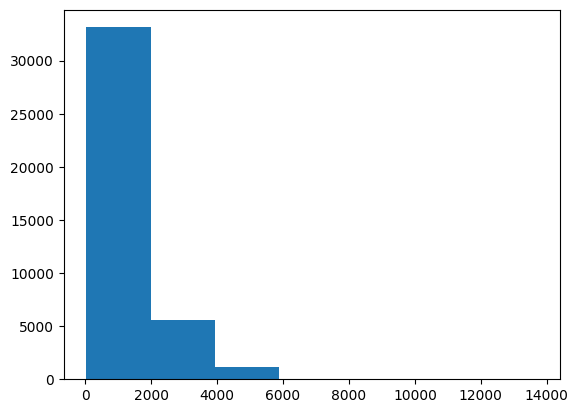

In [45]:
plt.hist(char_lens, bins=7);

In [46]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

3389

In [47]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
from tensorflow.keras.layers import TextVectorization

char_vectorizer2 = TextVectorization(max_tokens=70,
                                    output_sequence_length=500,
                                    standardize="lower_and_strip_punctuation")

In [48]:
# char_vectorizer2.adapt(train_chars2)

# The model is keep crashing after this and I am stuck on this for a few days so I will skip this for now.

## Model 4 - more complex model
Now I will try implementing a more complex model using bidirectional lstm and dropout layers.

In [49]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)# tokenize text and create embedding
x = layers.Dense(64, activation="relu")(pretrained_embedding)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(2, activation="softmax")(x)
model_4 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_4.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=test_dataset,
            validation_steps=int(0.1 * len(test_dataset)))

Epoch 1/3
125/125 [==============================] - 7s 43ms/step - loss: 0.5578 - accuracy: 0.7440 - val_loss: 0.3872 - val_accuracy: 0.8327
Epoch 2/3
125/125 [==============================] - 4s 35ms/step - loss: 0.3674 - accuracy: 0.8385 - val_loss: 0.3345 - val_accuracy: 0.8498
Epoch 3/3
125/125 [==============================] - 5s 36ms/step - loss: 0.3634 - accuracy: 0.8407 - val_loss: 0.3496 - val_accuracy: 0.8387


In [51]:
model_4_pred_probs = model_4.predict(test_dataset)
model_4_pred_probs

313/313 [==============================] - 9s 28ms/step


array([[5.5896682e-03, 9.9441034e-01],
       [9.2079824e-01, 7.9201736e-02],
       [9.1156000e-01, 8.8440001e-02],
       ...,
       [9.9956685e-01, 4.3309070e-04],
       [4.7784686e-02, 9.5221525e-01],
       [9.9400640e-01, 5.9935795e-03]], dtype=float32)

In [52]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 1, 0])>

In [53]:
model_4_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 84.23,
 'precision': 0.8463258306592836,
 'recall': 0.8423,
 'f1': 0.8419364206619977}

# Conclusion
All the models were pretty close to each other. 
We will use the last model in the next part.

In [54]:
# Saving the model
model_4.save("IMDB_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
